In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
sess = tf.InteractiveSession()

In [2]:
! wget www.math.uah.edu/stat/data/Fisher.csv

--2016-11-25 14:52:15--  http://www.math.uah.edu/stat/data/Fisher.csv
Resolving www.math.uah.edu... 146.229.1.10
Connecting to www.math.uah.edu|146.229.1.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [text/csv]
Saving to: 'Fisher.csv.2'

Fisher.csv.2        100%[=====================>]   2.17K  --.-KB/s   in 0s     

2016-11-25 14:52:16 (118 MB/s) - 'Fisher.csv.2' saved [2218/2218]



In [2]:
iris = pd.read_csv('Fisher.csv', 
                   skiprows=1, names=['target', 'petal_width', 'petal_length', 'sepal_width', 'sepal_length'])

iris.head()

,target,petal_width,petal_length,sepal_width,sepal_length
0,0,2,14,33,50
1,1,24,56,31,67
2,1,23,51,31,69
3,0,2,10,36,46
4,1,20,52,30,65


In [3]:
# number of input features + 1 constant term
feature_columns = iris.columns[1:]
feature_columns = ['sepal_length', 'petal_width']
D = len(feature_columns) + 1

n_samples = iris.shape[0]
C = iris.target.nunique()

In [4]:
train_X = np.hstack((
        np.ones(shape=(n_samples, 1)), 
        iris[feature_columns].values))
train_Y = iris.target.values

train_X[:10,:]

array([[  1.,  50.,   2.],
       [  1.,  67.,  24.],
       [  1.,  69.,  23.],
       [  1.,  46.,   2.],
       [  1.,  65.,  20.],
       [  1.,  58.,  19.],
       [  1.,  57.,  13.],
       [  1.,  63.,  16.],
       [  1.,  49.,  17.],
       [  1.,  70.,  14.]])

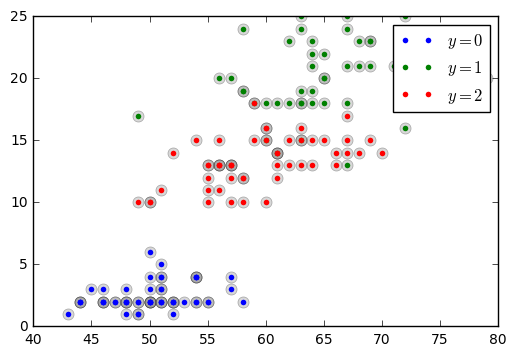

In [74]:
def plot_result(predicted_classes=None):

    if predicted_classes is None:
        plt.plot(train_X[:, 1], train_X[:, 2], 'o', ms=8, alpha=.3, color='grey');
    else:
        for c in range(C):
            mask = predicted_classes == c
            plt.plot(train_X[mask, 1], train_X[mask, 2], 'o', ms=8, alpha=.3, mec='none')
    plt.gca().set_prop_cycle(None)
    for c in range(C):
        mask = iris.target.values == c    
        plt.plot(train_X[mask, 1], train_X[mask, 2], 'o', ms=4, mec='none', label='$y = {}$'.format(c));
    plt.legend()
    
plot_result()

## Model and cost function

In [75]:
X = tf.placeholder("float", shape = [None, D])
Y = tf.placeholder("int32", shape = [None])

W = tf.Variable(tf.zeros_initializer(shape=(D, C)))
sess.run(W.initializer)

scores = tf.matmul(X, W)

probabilities = tf.nn.softmax(scores)

In [76]:
probabilities

<tf.Tensor 'Softmax_6:0' shape=(?, 3) dtype=float32>

In [77]:
sess.run(probabilities, feed_dict={X: train_X[:5, :]})

array([[ 0.33333334,  0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334,  0.33333334]], dtype=float32)

In [78]:
softmax_sample_losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=probabilities,
    labels=Y)

softmax_sample_losses

<tf.Tensor 'SparseSoftmaxCrossEntropyWithLogits_7/SparseSoftmaxCrossEntropyWithLogits:0' shape=(?,) dtype=float32>

In [79]:
softmax_loss = tf.reduce_mean(softmax_sample_losses)
print('batch average loss', sess.run(softmax_loss, feed_dict={X: train_X[:5, :], Y: train_Y[:5]}))

sess.run(softmax_sample_losses, feed_dict={X: train_X[:5, :], Y: train_Y[:5]})

batch average loss 1.09861


array([ 1.09861231,  1.09861231,  1.09861231,  1.09861231,  1.09861231], dtype=float32)

n_correct_samples / n_samples = 50 150


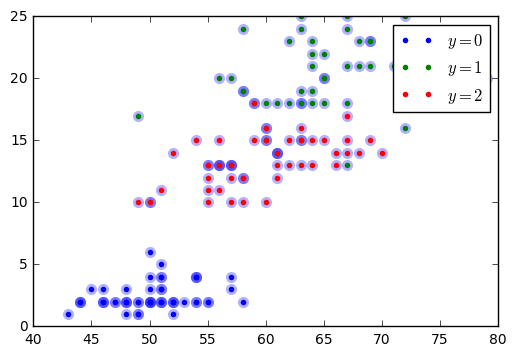

In [80]:
predicted_probs = sess.run(probabilities, feed_dict={X: train_X})
predicted_classes = predicted_probs.argmax(axis=1)
# classify everyone to the same class :/
n_correct_samples = np.sum(predicted_classes == train_Y)
print('n_correct_samples / n_samples =', n_correct_samples, n_samples)

plot_result(predicted_classes)

## Optimizing the cost function

 * Copy the boilerplate code from the last session (https://github.com/pilipolio/schibsted-study/blob/master/notebooks/201611_logistic_regression.ipynb, cell 43)
 * Replace the `logistic_loss` with the `batch_los
 * Remove or adapt the `fitted_ws[epoch, :] = fitted_w.ravel()` line because we now have more weights
 * Use code above to print the number of correct predictions and plot the final result
 * decrease the learning rate to something slightly lower than .2

Epoch:    0, cost=1.0986
n_correct_samples / n_samples = 50 150
Epoch:   10, cost=1.0755
n_correct_samples / n_samples = 50 150
Epoch:   20, cost=1.0132
n_correct_samples / n_samples = 50 150
Epoch:   30, cost=1.0981
n_correct_samples / n_samples = 50 150
Epoch:   40, cost=0.9471
n_correct_samples / n_samples = 85 150
Epoch:   50, cost=0.8962
n_correct_samples / n_samples = 100 150
Epoch:   60, cost=0.8687
n_correct_samples / n_samples = 100 150
Epoch:   70, cost=0.8543
n_correct_samples / n_samples = 100 150
Epoch:   80, cost=0.8015
n_correct_samples / n_samples = 117 150
Epoch:   90, cost=0.8058
n_correct_samples / n_samples = 129 150


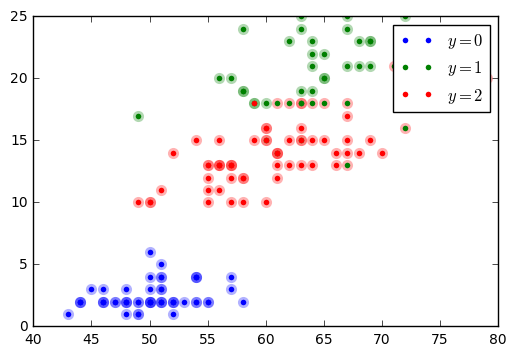

In [85]:
# Parameters
learning_rate = 0.01
n_epochs = 100
display_step = 10

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(softmax_loss)

fitted_ws = np.zeros((n_epochs, D*C))
sess.run(tf.initialize_all_variables())

for epoch in range(n_epochs):

    _, fitted_w, loss_value, predicted_probs = sess.run(
        fetches=[optimizer, W, softmax_loss, probabilities],
        feed_dict={X: train_X, Y: train_Y})
    fitted_ws[epoch, :] = fitted_w.ravel()
    if (epoch) % display_step == 0:
        print("Epoch: {:4d}, cost={:.4f}".format(epoch, loss_value))
        predicted_classes = predicted_probs.argmax(axis=1)
        # classify everyone to the same class :/
        n_correct_samples = np.sum(predicted_classes == train_Y)
        print('n_correct_samples / n_samples =', n_correct_samples, n_samples)

plot_result(predicted_classes)